{   'C': array([[ 2.80454469]]),
    'R': array([-1.87098279]),
    'ls': array([-0.82308671]),
    'sf': array([-0.28550909]),
    'sn': array(-1.610784015544342),
    'zu': array([[-0.56638047],
       [-0.26271276],
       [ 0.09830039],
       [ 0.47406804],
       [ 0.84913807],
       [ 1.16002262],
       [ 1.31448193],
       [ 1.48508516],
       [ 1.22667755],
       [ 1.80004985]])}


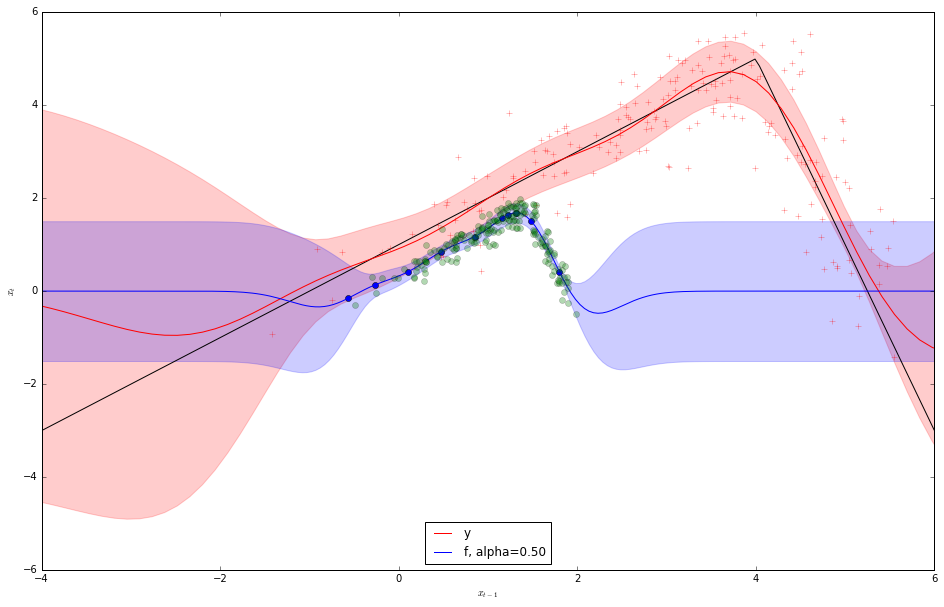

epoch 0/50


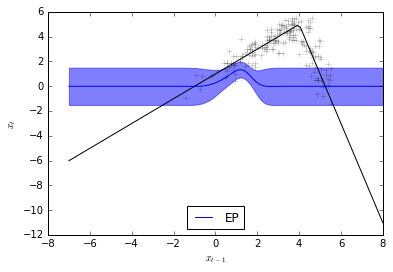

epoch 1/50
epoch 2/50
epoch 3/50
epoch 4/50
epoch 5/50


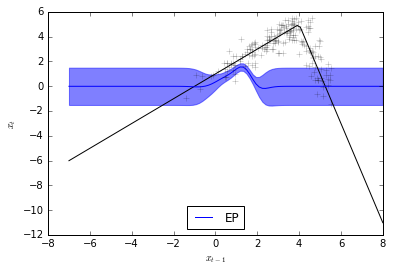

epoch 6/50
epoch 7/50
epoch 8/50
epoch 9/50
epoch 10/50


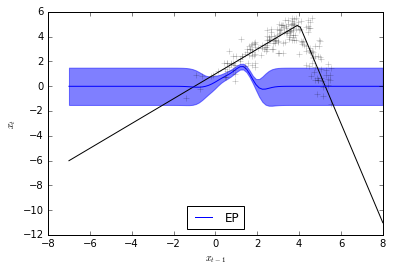

epoch 11/50
epoch 12/50
epoch 13/50
epoch 14/50
epoch 15/50


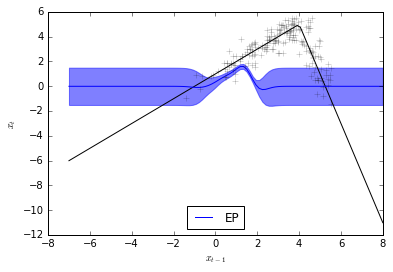

epoch 16/50
epoch 17/50
epoch 18/50
epoch 19/50
epoch 20/50


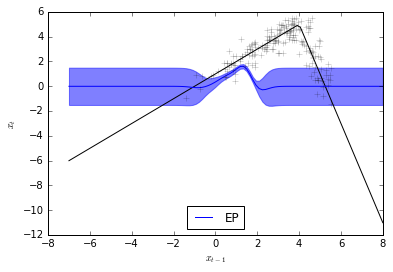

epoch 21/50
epoch 22/50
epoch 23/50
epoch 24/50
epoch 25/50


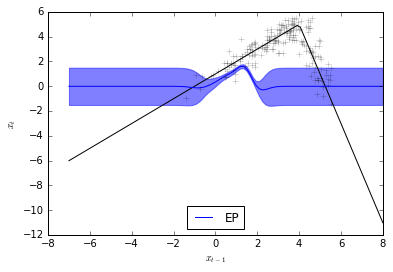

epoch 26/50
epoch 27/50
epoch 28/50
epoch 29/50
epoch 30/50


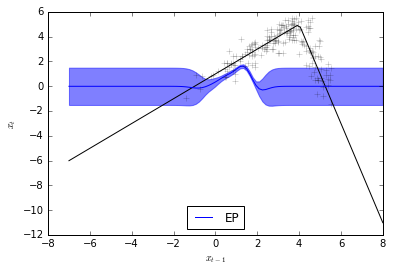

epoch 31/50
epoch 32/50
epoch 33/50
epoch 34/50
epoch 35/50


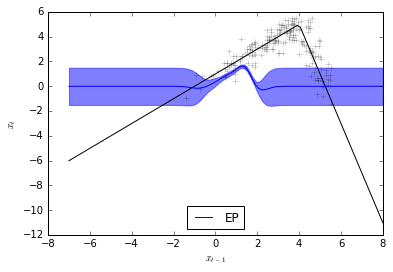

epoch 36/50
epoch 37/50
epoch 38/50
epoch 39/50
epoch 40/50


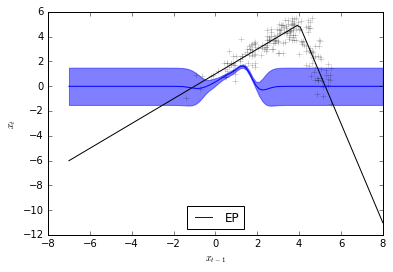

epoch 41/50
epoch 42/50
epoch 43/50
epoch 44/50
epoch 45/50


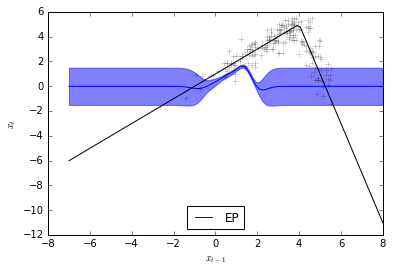

epoch 46/50
epoch 47/50
epoch 48/50
epoch 49/50


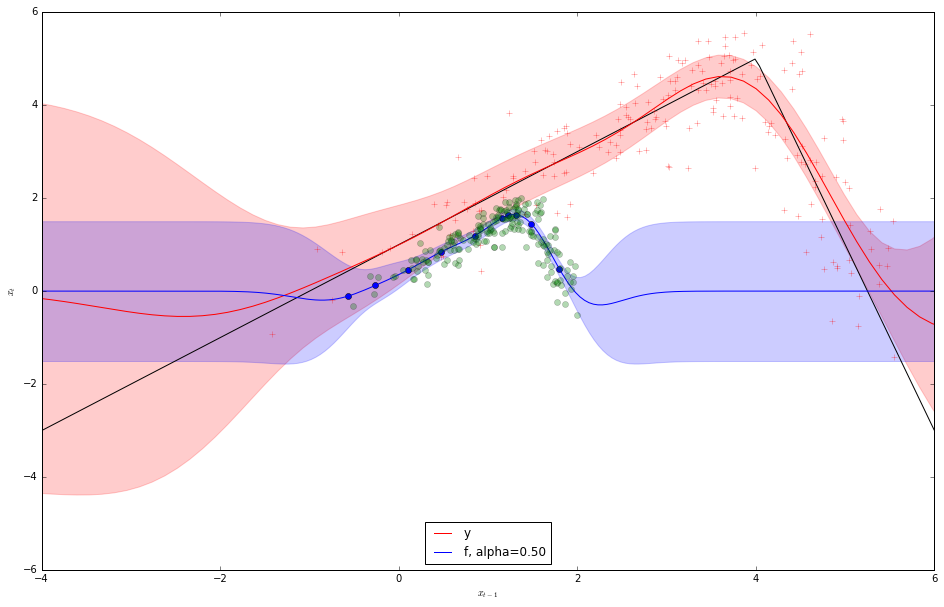

In [1]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import os, sys
sys.path.insert(0, "../")
import geepee.aep_models as aep
import geepee.ep_models as ep
import pdb
%matplotlib inline

np.random.seed(42)

def test_kink():
    def kink_true(x):
        fx = np.zeros(x.shape)
        for t in range(x.shape[0]):
            xt = x[t]
            if xt < 4:
                fx[t] = xt + 1
            else:
                fx[t] = -4*xt + 21
        return fx

    def kink(T, process_noise, obs_noise, xprev=None):
        if xprev is None:
            xprev = np.random.randn()
        y = np.zeros([T, ])
        x = np.zeros([T, ])
        xtrue = np.zeros([T, ])
        for t in range(T):
            if xprev < 4:
                fx = xprev + 1
            else:
                fx = -4*xprev + 21

            xtrue[t] = fx
            x[t] = fx + np.sqrt(process_noise)*np.random.randn()
            xprev = x[t]
            y[t] = x[t] + np.sqrt(obs_noise)*np.random.randn()

        return xtrue, x, y
    
    def plot(model):
        # make prediction on some test inputs
        N_test = 200
        x_test = np.linspace(-4, 6, N_test)
        x_test = np.reshape(x_test, [N_test, 1])
        zu = model.sgp_layer.zu
        mu, vu = model.predict_f(zu)
        mf, vf = model.predict_f(x_test)
        my, vy = model.predict_y(x_test)
        C = model.get_hypers()['C']
        # plot function
        fig = plt.figure(figsize=(16,10))
        ax = fig.add_subplot(111)
        ax.plot(x_test[:,0], kink_true(x_test[:,0]), '-', color='k')
        ax.plot(C[0,0]*x_test[:,0], my[:,0], '-', color='r', label='y')
        ax.fill_between(
            C[0,0]*x_test[:,0], 
            my[:,0] + 2*np.sqrt(vy[:, 0, 0]), 
            my[:,0] - 2*np.sqrt(vy[:, 0, 0]), 
            alpha=0.2, edgecolor='r', facecolor='r')
        ax.plot(zu, mu, 'ob')
        ax.plot(x_test[:,0], mf[:,0], '-', color='b', label='f, alpha=%.2f' % alpha)
        ax.fill_between(
            x_test[:,0], 
            mf[:,0] + 2*np.sqrt(vf[:,0]), 
            mf[:,0] - 2*np.sqrt(vf[:,0]), 
            alpha=0.2, edgecolor='b', facecolor='b')
        ax.plot(
            model.emi_layer.y[0:model.N-1], 
            model.emi_layer.y[1:model.N], 
            'r+', alpha=0.5)
        mx, vx = model.get_posterior_x()
        ax.plot(mx[0:model.N-1], mx[1:model.N], 'og', alpha=0.3)
        ax.set_xlabel(r'$x_{t-1}$')
        ax.set_ylabel(r'$x_{t}$')
        ax.set_xlim([-4, 6])
        ax.legend(loc='lower center')
        plt.show()


    T = 200
    process_noise = 0.2
    obs_noise = 0.1
    (xtrue, x, y) = kink(T, process_noise, obs_noise)
    y_train = np.reshape(y, [y.shape[0], 1])
    # pdb.set_trace()

    alpha = 0.5
    Dlatent = 1
    Dobs = 1
    M = 10
    C = 1*np.ones((1, 1))
    R = np.ones(1)*np.log(obs_noise)/2
    lls = np.reshape(np.log(2), [Dlatent, ])
    lsf = np.reshape(np.log(2), [1, ])
    zu = np.linspace(-2, 5, M)
    zu = np.reshape(zu, [M, 1])
    lsn = np.log(process_noise)/2
    params = {'ls': lls, 'sf': lsf, 'sn': lsn, 'R': R, 'C': C, 'zu': zu}

    # create model
    model = aep.SGPSSM(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1000)
    hypers = model.init_hypers(y_train)
    for key in params.keys():
        hypers[key] = params[key]
    model.update_hypers(hypers, alpha)
    # optimise
    model.optimise(method='L-BFGS-B', alpha=alpha, maxiter=3000, reinit_hypers=False)
    
    opt_hypers = model.get_hypers()
    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    keys = ['ls', 'sf', 'zu', 'sn', 'C', 'R']
    params_dict = {}
    for key in keys:
        params_dict[key] = opt_hypers[key]
    pp.pprint(params_dict)
    plot(model)
    
    # create EP model
    model_ep = ep.SGPSSM(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1000)
    model_ep.update_hypers(opt_hypers)
    # run EP
    model_ep.inference(no_epochs=50, alpha=alpha, parallel=True, decay=0.99)
    plot(model_ep)
test_kink()